In [1]:
!pip install imblearn

# Milestone 3: Preprocessing

In the previous milestone, we merged the **TCG** and **Price Guide** datasets. We saved the resulting dataframe as a `.csv` file. For this milestone, we will first begin by normalizing our data and encoding our categorical variables. We will then train and evaluate our first model. Let's begin my importing important libraries. 

### Imports

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import zscore

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score

### Data Loading

We will begin by loading our merged dataset from the previous milestone. Then, we use `.dropna()` to drop rows that contain any null values. Then, we have printed some statistics about the dataset.

In [7]:
price_guide_tcg = pd.read_csv("price_guide_tcg_cleaned.csv", low_memory=False)
price_guide_tcg.dropna()
price_guide_tcg.describe()

,id,loose-price,graded-price,box-only-price,manual-only-price,bgs-10-price,condition-17-price,condition-18-price,sales-volume,hp
count,3.030000e+04,30132.000000,23242.000000,23345.000000,22502.000000,22504.000000,22653.000000,22507.000000,30300.000000,25631.000000
mean,1.815578e+06,9.113746,40.473400,50.029936,169.867231,260.751890,144.303368,101.864726,48.108482,96.110569
std,1.610918e+06,57.197150,203.630556,280.753070,1698.911993,2705.228337,641.144056,1019.301576,102.838685,52.140362
min,2.522800e+04,0.010000,0.140000,0.990000,0.980000,0.990000,1.000000,1.000000,1.000000,10.000000
25%,8.887088e+05,1.340000,12.060000,13.000000,34.910000,52.000000,44.000000,21.000000,5.000000,60.000000
50%,9.596655e+05,1.990000,16.065000,18.000000,42.720000,65.000000,50.000000,26.000000,12.000000,80.000000
75%,2.254008e+06,4.292500,29.807500,33.000000,90.045000,137.000000,99.990000,54.000000,38.000000,120.000000
max,7.747251e+06,4223.260000,17033.540000,27550.000000,221599.740000,332400.000000,42316.000000,132960.000000,1837.000000,340.000000


Below, we can see that there are 29 features in our dataset. names for these features are printed below. 

In [9]:
print('Number of features', price_guide_tcg.shape[1])
print(price_guide_tcg.columns)

Number of features 29
Index(['tcg_id', 'id', 'console-name', 'product-name', 'loose-price',
       'graded-price', 'box-only-price', 'manual-only-price', 'bgs-10-price',
       'condition-17-price', 'condition-18-price', 'sales-volume',
       'release-date', 'set', 'series', 'publisher', 'generation',
       'release_date', 'artist', 'name', 'set_num', 'types', 'supertype',
       'subtypes', 'hp', 'weaknesses', 'rarity', 'legalities', 'resistances'],
      dtype='object')


# Preprocessing: Categorical Variables

## 1. Dropping categories with very few observations

Below, we have shown the value counts for `types`, `generation` and `rarity`. One can notice that for some categories within each of these categorical variables, we have very few observations. For instance, there are only two observations where a Pokemon's type is `['Water', 'Fire']`. This may lead to a lot of noise in our dataset. 

This could negatively impact our training because there is a very insufficient representation of these categories in the dataset.

#### Value counts for `types`

In [11]:
price_guide_tcg['types'].value_counts()

types
['Water']                    3787
['Grass']                    3706
['Psychic']                  3331
['Colorless']                3324
['Fighting']                 2853
['Fire']                     2251
['Lightning']                2177
['Darkness']                 1602
['Metal']                    1275
['Dragon']                    666
['Fairy']                     392
['Grass', 'Darkness']          21
['Fighting', 'Darkness']       19
['Lightning', 'Metal']         18
['Darkness', 'Metal']          15
['Water', 'Darkness']          15
['Fire', 'Metal']              13
['Water', 'Metal']             12
['Psychic', 'Metal']           11
['Fire', 'Darkness']           11
['Lightning', 'Darkness']      10
['Fighting', 'Metal']           8
['Psychic', 'Darkness']         6
['Fire', 'Grass']               6
['Grass', 'Metal']              6
['Fire', 'Water']               4
['Metal', 'Fighting']           2
['Fairy', 'Psychic']            2
['Lightning', 'Grass']          2
['Fairy'

#### Value counts for `rarity`

In [13]:
price_guide_tcg['rarity'].value_counts()

rarity
Common                       8768
Uncommon                     8549
Rare                         4782
Rare Holo                    3380
Promo                        1115
Rare Ultra                    776
Rare Holo EX                  335
Rare Secret                   331
Rare Rainbow                  325
Rare Holo V                   280
Rare Holo GX                  172
Rare Shiny                    149
Illustration Rare             123
Rare Holo VMAX                122
Ultra Rare                    102
Double Rare                    96
Rare Holo LV.X                 57
Rare Holo VSTAR                56
Special Illustration Rare      53
Rare Shiny GX                  35
Trainer Gallery Rare Holo      34
Hyper Rare                     29
Radiant Rare                   28
Rare BREAK                     27
Rare Prism Star                27
Rare Holo Star                 26
Rare Prime                     26
Rare Shining                   26
LEGEND                         18
Rare AC

#### Value counts for `generation`

In [15]:
price_guide_tcg['generation'].value_counts()

generation
Eighth     5888
Seventh    5015
Third      3412
Sixth      3148
Fifth      2887
Fourth     2668
Ninth      2282
Second     1989
First      1507
Fourth     1204
Other       161
Name: count, dtype: int64

### Copying relevant parts of our dataset into a new Dataframe

For the purposes of our model described in later cells, we will copy over relevant features from our dataset to a new DataFrame. 

In [17]:
subset_df = price_guide_tcg[['rarity', 'types', 'generation', 'bgs-10-price', 'graded-price', 'hp', 'sales-volume']].copy()
print(subset_df.head())

         rarity          types generation  bgs-10-price  graded-price     hp  \
0      Uncommon            NaN      Sixth           NaN           NaN    NaN   
1      Uncommon            NaN      Sixth           NaN           NaN    NaN   
2      Uncommon            NaN      Sixth           NaN           NaN    NaN   
3      Uncommon            NaN      Sixth          58.0         15.11    NaN   
4  Rare Holo EX  ['Lightning']      Sixth          62.0         28.09  170.0   

   sales-volume  
0           5.0  
1           1.0  
2           1.0  
3           7.0  
4          81.0  


### Setting thresholds for the minimum counts

In [19]:
thresholds = {
    'types': 1000  ,        # Minimum count for 'types'
    'rarity': 1000  ,    # Minimum count for 'rarity'
    'generation':1500
}

### Removing rows with rare categories for each column based on the thresholds

In [21]:
for col, threshold in thresholds.items():
    counts = subset_df[col].value_counts()
    valid_categories = counts[counts >= threshold].index
    subset_df = subset_df[subset_df[col].isin(valid_categories)]

### Checking if the removal was successul

In [23]:
subset_df['types'].value_counts()

types
['Water']        2886
['Grass']        2857
['Psychic']      2525
['Colorless']    2506
['Fighting']     2263
['Fire']         1658
['Lightning']    1590
['Darkness']     1236
['Metal']         966
Name: count, dtype: int64

In [24]:
subset_df['rarity'].value_counts()

rarity
Common       7388
Uncommon     4588
Rare         3985
Rare Holo    2526
Name: count, dtype: int64

In [25]:
subset_df['generation'].value_counts()

generation
Eighth     3482
Seventh    2978
Third      2536
Fourth     2206
Fifth      2049
Sixth      1983
Ninth      1629
Second     1624
Name: count, dtype: int64

Thus, we can see that for each of these categorical variables, we have ensured that there is a high density of observations present in our dataset. 

Next, we will verify the shape of this new DataFrame:

In [27]:
subset_df.shape

(18487, 7)

We will also drop any rows with null values

In [29]:
subset_df = subset_df.dropna()

In [30]:
subset_df.shape

(12759, 7)

### First few columns of the new DataFrame

In [32]:
subset_df.head()

,rarity,types,generation,bgs-10-price,graded-price,hp,sales-volume
9,Uncommon,['Grass'],Sixth,58.0,15.01,70.0,7.0
12,Common,['Psychic'],Sixth,36.0,9.28,60.0,29.0
13,Common,['Psychic'],Sixth,90.0,16.34,60.0,14.0
16,Uncommon,['Grass'],Sixth,58.0,23.00,120.0,24.0
17,Uncommon,['Grass'],Sixth,58.0,15.01,120.0,12.0


### Examining relationships in our data

In [34]:
type_means = subset_df.groupby('types')['bgs-10-price'].mean().sort_values()
rarity_means = subset_df.groupby('rarity')['bgs-10-price'].mean().sort_values()

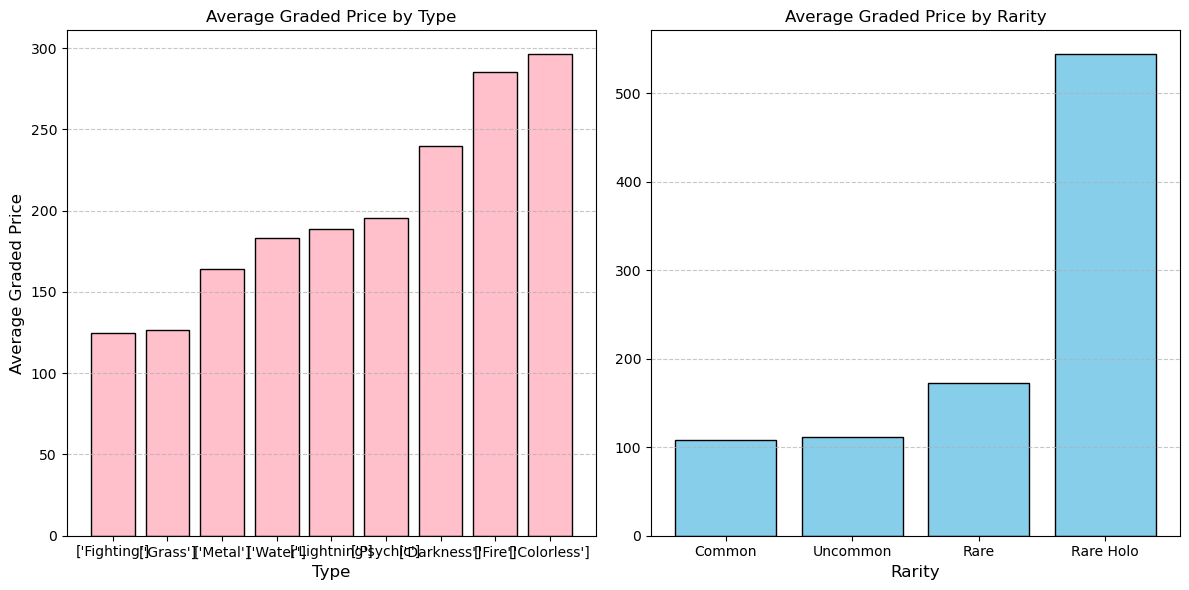

In [35]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.bar(type_means.index, type_means, color='pink', edgecolor='black')
plt.title('Average Graded Price by Type', fontsize=12)
plt.xlabel('Type', fontsize=12)
plt.ylabel('Average Graded Price', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.bar(rarity_means.index, rarity_means, color='skyblue', edgecolor='black')
plt.title('Average Graded Price by Rarity', fontsize=12)
plt.xlabel('Rarity', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()


# Model 1: Random Forest

In this model, we are using a **Random Forest Classifier** to predict the **rarity** of Pokemon cards based on a combination of numerical as well as categorical features.

#### Features :
1. **Categorical Features**:
   - `types`: Represents the type/category of the item.
   - `generation`: Refers to the generation or version of the item.

2. **Numerical Features**:
   - `bgs-10-price`: The graded price of the item in mint condition.
   - `graded-price`: The general graded price of the item.
   - `hp`: Represents the item's hit points (a measure of power or health).
   - `sales-volume`: Indicates the volume of sales for the item.

#### Target Variable :
- **rarity**: The classification label indicating how rare the item is.

**We will first conduct our categorical variable encoding:**

#### One-hot encoding on categorical variables (`types` and `generation`)

In [38]:
encoded_df = pd.get_dummies(subset_df, columns=['types', 'generation'], drop_first=True)

#### Defining features and target

In [40]:
features = ['bgs-10-price', 'graded-price', 'hp', 'sales-volume'] + \
           [col for col in encoded_df.columns if col.startswith('types_') or col.startswith('generation_')]
target = 'rarity'

#### Separating features and target

In [42]:
X = encoded_df[features]
y = encoded_df[target]

#### Next, we will create our Train-Test Split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

### Balancing the Dataset using SMOTE Oversampling

To further address the class imbalance mentioned before, we use overampling --- `SMOTE (Synthetic Minority Oversampling Technique)` . 

It creates synthetic samples for the minority class based on its nearest neighbors to ensure the classes are balanced. For more information, look at: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

Here, X_train and y_train are resampled to create a balanced dataset (X_resampled and y_resampled) for improved model training.

In [46]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

### Model Training
The **Random Forest Classifier** is trained on the processed data using k-fold cross-validation (5 splits) to evaluate its performance and reduce overfitting.

First, we iniitialize our model with a fixed random seed (random_state=42) for reproducibility. Then we fit the Random Forest model to the resampled dataset (`X_resampled` and `y_resample`d) created using SMOTE.

In [48]:
model = RandomForestClassifier(random_state=123)
model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=123)

### K - fold validation
We did the followng: 
- Splits the data into 5 folds for training and validation.
- We train and evaluate model on different subsets of the data to prevent overfitting
- `cv_scores` stores accuracy scores for each fold.

In [50]:
kf = KFold(n_splits=5, shuffle=True, random_state=123)
cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=kf, scoring='accuracy')

### Cross Validation Accuracy Scores

[0.77840344 0.77475985 0.76507621 0.75878065 0.77269715]


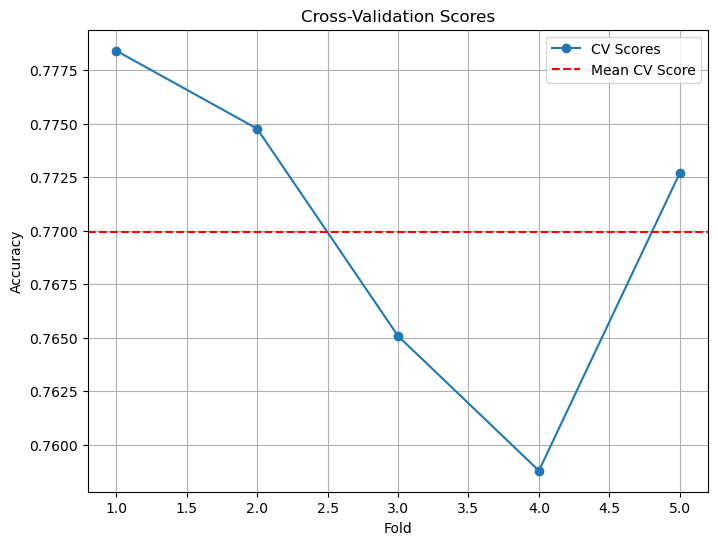

In [52]:
print(cv_scores)


plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', linestyle='-', label='CV Scores')
plt.axhline(np.mean(cv_scores), color='red', linestyle='--', label='Mean CV Score')
plt.title('Cross-Validation Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show() 

Retraining the model on the entire resampled dataset after cross-validation for final predictions and evaluation.

In [54]:
model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=123)

### Training Curve

Here, we can analyze the training and testing accuracy.

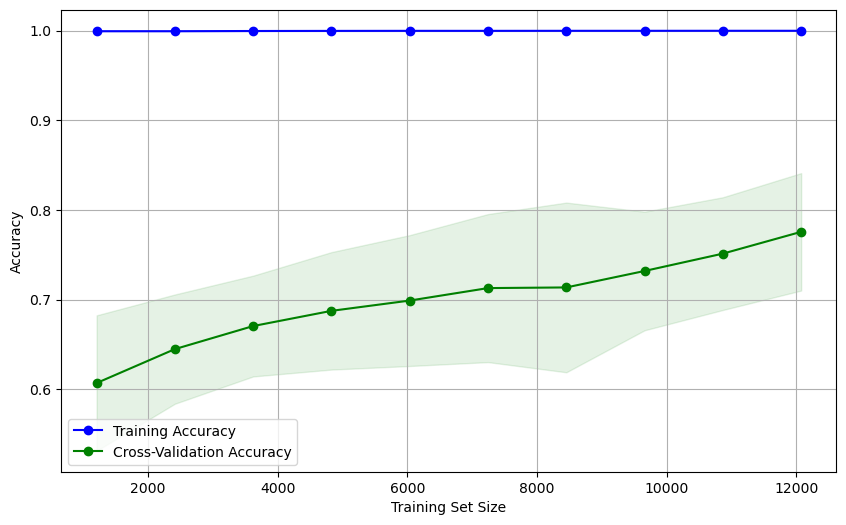

In [56]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X_resampled,
    y=y_resampled,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-Validation Accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### Evaluating our Random Forest

#### **Classification Report**:
- **Class-Specific Metrics**:
  - **Common**:
    - Precision: 0.82 → 82% of predictions for "Common" are correct.
    - Recall: 0.85 → 85% of actual "Common" instances are identified.
    - F1-Score: 0.84 → Balanced performance in terms of precision and recall.
  - **Rare**:
    - Lower precision (0.70) and recall (0.67) indicate more difficulty in predicting this class accurately.
  - **Rare Holo**:
    - Strong performance with F1-score of 0.82, suggesting the model predicts this class well.
  - **Uncommon**:
    - Moderate performance with F1-score of 0.71.

- **Overall Metrics**:
  - Accuracy: 0.76 → The model correctly predicts 76% of test samples.
  - Macro Avg:
    - Averages metrics across all classes equally, resulting in 0.76 for precision, recall, and F1-score.
  - Weighted Avg:
    - Averages metrics, weighted by class occurrences, yielding the same 0.76 because the classes are reasonably balanced.

#### **Confusion Matrix**:
- Rows: Actual classes.
- Columns: Predicted classes.
- Example Interpretations:
  - "Common" (row 1):
    - Correctly predicted: 653 instances.
    - Misclassified as "Rare": 27 instances.
    - Misclassified as "Rare Holo": 10 instances.
    - Misclassified as "Uncommon": 76 instances.
  - The matrix indicates where the model struggles, such as confusion between "Rare" and "Uncommon" or "Rare" and "Rare Holo".

#### **Accuracy**:
- While a 76.48% accuracy is decent, the confusion in predicting "Rare" and "Uncommon" suggests room for improvement.



In [90]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = model.predict(X_test)

### We get the following results from our classification report

1. **Accuracy (0.67)**:
   - The model correctly predicts the rarity of Pokémon cards **67% of the time**.
2. **Macro Average**:
   - **Precision, Recall, F1-Score (0.64)**:
3. **Weighted Average**:
   - **Precision, Recall, F1-Score (0.67)**:


In [94]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Common       0.83      0.85      0.84       892
        Rare       0.54      0.52      0.53       609
   Rare Holo       0.63      0.64      0.64       470
    Uncommon       0.58      0.57      0.58       581

    accuracy                           0.67      2552
   macro avg       0.64      0.64      0.64      2552
weighted avg       0.67      0.67      0.67      2552



### Confusion Matrix:

1. **Common**:
   - Most are correctly predicted (756), but some are misclassified as `Uncommon `(91) or other classes.
   - The model performs best on `Common` cards because they dominate the dataset and are easier to distinguish.

2. **Rare**:
   - 316 are correctly predicted, but many are confused with `Rare Holo` (119) and `Uncommon` (125).
   - This suggests the model struggles with finer distinctions between "Rare" and similar classes.

3. **Rare Holo**:
   - 300 are correctly predicted, but a significant number are misclassified as "Rare" (125).
   - This confusion is likely due to overlapping features between "Rare Holo" and "Rare."

4. **Uncommon**:
   - 334 are correctly identified, but there is confusion with `Common` (91) and "Rare" (116).
   - This indicates the model has difficulty separating `Uncommon` from other classes.


In [96]:
print(confusion_matrix(y_test, y_pred))

[[756  30  15  91]
 [ 49 316 119 125]
 [ 18 125 300  27]
 [ 91 116  40 334]]


### Final Accuracy

As mentioned before, the model correctly predicts the rarity of Pokémon cards for 67 cards oout of a 100

In [98]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.6684952978056427
